## Importing libraries and modules

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, cross_validate, RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, f1_score, log_loss, precision_score, recall_score, make_scorer
from scipy.stats import chi2_contingency

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

## Loading dataset and finding correlation between all variables

In [2]:
# Giving the names of the columns manually.
names = ["class","cap-shape", "cap-surface", "cap-color", "bruises?", "odor", "gill-attachment", "gill-spacing", 
         "gill-size", "gill-color", "stalk-shape", "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring",
         "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color", "ring-number", "ring-type",
         "spore-print-color", "population", "habitat"]
df = pd.read_csv("agaricus-lepiota.data", sep=",", names=names )
df.head(5)

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [3]:
# Check for any duplicate rows
df[df.duplicated()]

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat


In [4]:
#There are non-null values in the columns because the null values are represented by '?'.
#Thus, I will convert '?' to NaN and print df.info() again
df[df == '?'] = np.nan
#print('Info on Dataframe')
print(df.info(), '\n')

for column in df.columns:
    print(f'Distinct values in {column}: {df[column].unique()}')
    
#The column 'veil-type' have a constant value of 'p' for all observations and thus I will drop this column as it is meaningless.
df.drop(columns=['veil-type'], inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises?                  8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                5644 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

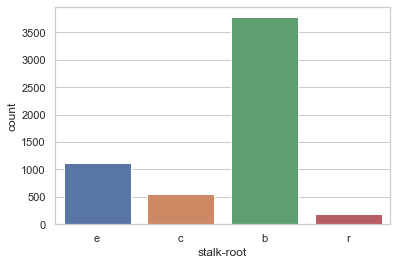

In [5]:
#I use a barplot to see the count of unique values in the column 'stalk-root'.
sns.set_theme(style="whitegrid")
sns.countplot(x="stalk-root",data=df)

In [6]:
#Firstly, I check the correlation for all variables.

In [7]:
# Cramer's V function for finding correlation between 2 features

def cramers_V(var1,var2) :
    crosstab = np.array(pd.crosstab(var1,var2)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return (stat/(obs*mini))

In [8]:
# Forming correlation matrix of df
rows= []

# A for loop that takes a feature and second feature to run Cramer's V function.  
for var1 in df:
    col = []
    for var2 in df :
        cramers =cramers_V(df[var1], df[var2]) # Cramer's V test
        col.append(round(cramers,2))
    rows.append(col)
cramers_results = np.array(rows)
df_corr = pd.DataFrame(cramers_results, columns = df.columns, index =df.columns)

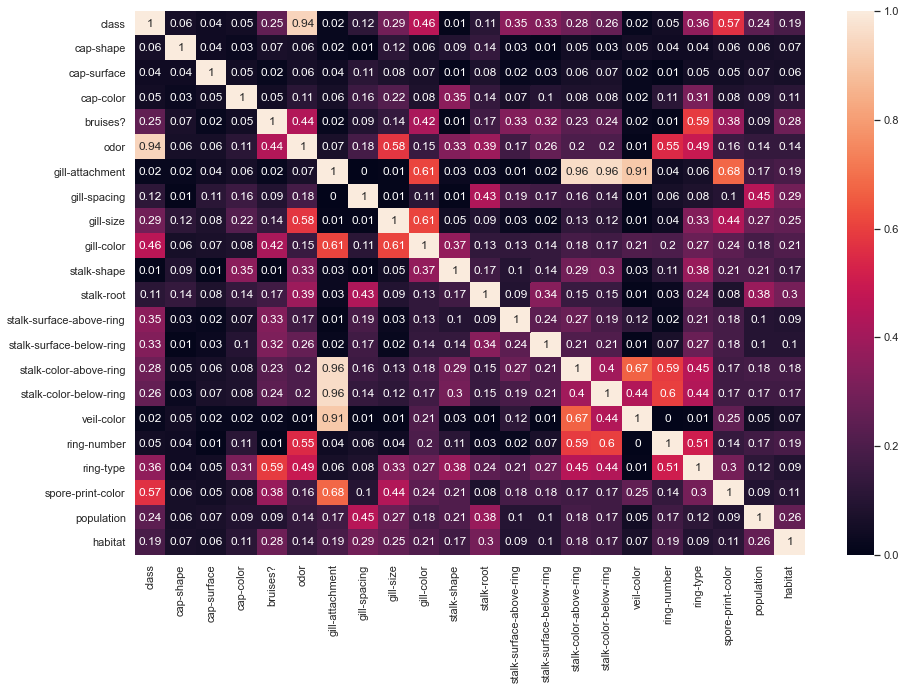

In [9]:
# Plotting correlation heatmap 
plt.figure(figsize=(15,10))
with sns.axes_style("white"):
    ax = sns.heatmap(df_corr,vmin=0., vmax=1, annot=True)
plt.show()

## Spilting the dataset into 2 arrays: Features and Response variable.

In [10]:
df_X = df.drop(columns=['class'])
df_y = df['class']

## kNN Imputation for Categorical Missing Values
I will be using kNN Imputation to predict the null values of the feature 'stalk-root_missing'. I do not want to replace the null values with the mode. Thus, I am using kNN Imputation to predict the null values based on other features.

In [11]:
# Using SimpleImputer to replace Nan values with 'Missing'
imp_missing = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')
df_simpleimputer=imp_missing.fit_transform(df_X)

In [12]:
# Using one hot encoder to encode categorical features to do the model and for kNN imputation.
# If I did not replace Nan values with 'Missing', one hot encoder would replace Nan values with 0 which would not be 
# suitable for using kNN imputation as the missing values already have a value of 0.
# Thus, I need to create another column for the missing values.
enc = OneHotEncoder()
df_enc=enc.fit_transform(df_simpleimputer).toarray()
df_enc

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
# Using enc.get_feature_names to get the column names and changing it into a dataframe.
df_encoded = pd.DataFrame(data = df_enc , columns = enc.get_feature_names(df_X.columns))
# Locating rows where 'stalk-root_missing' would equals to 1 and changing the values in 
# the columns ('stalk-root_b','stalk-root_c','stalk-root_e','stalk-root_r') of the rows to be np.nan for kNN imputation.
df_encoded.loc[df_encoded['stalk-root_missing'] == 1, ['stalk-root_b','stalk-root_c','stalk-root_e','stalk-root_r']] = np.nan
# Dropping the 'stalk-root_missing' column as we do not need this row anymore
df_changed = df_encoded.drop(columns=['stalk-root_missing'])

In [14]:
# Initiate KNNImputer and fitting and transforming it on the whole dataset.
imputer = KNNImputer(n_neighbors=1)
df_imputed = imputer.fit_transform(df_changed)
df_knnimputed = pd.DataFrame(data = df_imputed , columns = df_changed.columns)

In [15]:
# Label Encode the target 'class'
le = preprocessing.LabelEncoder()
array_le = le.fit_transform(df_y)
df_le = pd.DataFrame(data = array_le , columns = ['class'])

In [26]:
# Finally, I will be joining the class and features together after encoding 
# both.
df_final = pd.concat([df_le, df_knnimputed], axis=1)
df_final.head()

# Class labels of 1 are positive which are mushrooms that are poisonous.
# Class labels of 0 are negative which are mushrooms that are edible.

,class,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Defining features and target
X = df_final.drop(columns=['class'])
y = df_final['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Creating baseline model using logistic regression

In [20]:
#Training the baseline model
logreg = LogisticRegression()

# using cross validation and evaluate model
scoring = ['accuracy', 'f1', 'precision', 'recall']
baseline_cv_scores = cross_validate(logreg, X, y, scoring=scoring, cv=10, return_estimator=True, return_train_score= True)

print('Accuracy score of each train fold: {}'.format(baseline_cv_scores['train_accuracy']))
print("Average Accuracy score of 10 train folds: {}\n".format(np.mean(baseline_cv_scores['train_accuracy'])))

print('Accuracy score of each test fold: {}'.format(baseline_cv_scores['test_accuracy']))
print("Average Accuracy score of 10 test folds: {}\n".format(np.mean(baseline_cv_scores['test_accuracy'])))

print('F1 score of each test fold: {}'.format(baseline_cv_scores['test_f1']))
print("Average F1 score of 10 test folds: {}\n".format(np.mean(baseline_cv_scores['test_f1'])))

print('Precision score of each test fold: {}'.format(baseline_cv_scores['test_precision']))
print("Average Precision score of 10 test folds: {}\n".format(np.mean(baseline_cv_scores['test_precision'])))

print('Recall score of each test fold: {}'.format(baseline_cv_scores['test_recall']))
print("Average Recall score of 10 test folds: {}\n".format(np.mean(baseline_cv_scores['test_recall'])))

Accuracy score of each train fold: [1.         1.         1.         1.         0.99972648 1.
 1.         1.         0.99958972 1.        ]
Average Accuracy score of 10 train folds: 0.9999316192560175

Accuracy score of each test fold: [0.83394834 1.         1.         1.         0.99753695 1.
 1.         1.         0.74876847 1.        ]
Average Accuracy score of 10 test folds: 0.9580253758202606

F1 score of each test fold: [0.79198767 1.         1.         1.         0.99744246 1.
 1.         1.         0.79310345 1.        ]
Average F1 score of 10 test folds: 0.9582533576862435

Precision score of each test fold: [1.         1.         1.         1.         1.         1.
 1.         1.         0.65714286 1.        ]
Average Precision score of 10 test folds: 0.9657142857142856

Recall score of each test fold: [0.65561224 1.         1.         1.         0.99489796 1.
 1.         1.         1.         1.        ]
Average Recall score of 10 test folds: 0.9650510204081634



The average accuracy score on training set is near to 0.99 and the average accuracy score on testing set is 0.95 which is not too far off from the average accuracy score on training set. 

The average precision score of 0.96 states that 96% of the poisionous class predictions actually belong to the poisonous class.

The average recall score of 0.96 states that the model captured 96% of the actual poisonous mushrooms.

I will now work on the algorithm to achieve a higher accuracy than our baseline model accuracy.
I will use Voting Classfifier.

## Implementing Voting Classfifier
I will be using 3 models for voting classfifier. 

1) Logistic Regression 

2) k-Nearest Neighbours

3) SVC

### Logistic Regression
I will be tuning the hyperparameters for Logistic Regression and then use the best hyperparameters for cross validation to examine how well do these hyperparameters work.

In [23]:
# Finding best hyperameters for Logistic Regression
lr = LogisticRegression(max_iter = 200, penalty = 'l2')
c_space =  np.logspace(-4, 4, 50)

param_dist = {'C' : c_space}
lr_cv = GridSearchCV(lr, param_dist, cv=10)
lr_cv.fit(X,y)
print("Tuned Logistic Regression Parameters: {} \n".format(lr_cv.best_params_)) 
lr_hyperparameters = list(lr_cv.best_params_.values())

tuned_lr =  LogisticRegression(C= lr_hyperparameters[0],
                               penalty = 'l2',
                               max_iter = 200)

scoring = ['accuracy', 'f1', 'precision', 'recall']
tunedlr_cv_scores = cross_validate(tuned_lr, X, y, scoring=scoring, cv=10, return_estimator=True, return_train_score= True)

print('Accuracy score of each train fold: {}'.format(tunedlr_cv_scores['train_accuracy']))
print("Average Accuracy score of 10 train folds: {}\n".format(np.mean(tunedlr_cv_scores['train_accuracy'])))

print('Accuracy score of each test fold: {}'.format(tunedlr_cv_scores['test_accuracy']))
print("Average Accuracy score of 10 test folds: {}\n".format(np.mean(tunedlr_cv_scores['test_accuracy'])))

print('F1 score of each test fold: {}'.format(tunedlr_cv_scores['test_f1']))
print("Average F1 score of 10 test folds: {}\n".format(np.mean(tunedlr_cv_scores['test_f1'])))

print('Precision score of each test fold: {}'.format(tunedlr_cv_scores['test_precision']))
print("Average Precision score of 10 test folds: {}\n".format(np.mean(tunedlr_cv_scores['test_precision'])))

print('Recall score of each test fold: {}'.format(tunedlr_cv_scores['test_recall']))
print("Average Recall score of 10 test folds: {}\n".format(np.mean(tunedlr_cv_scores['test_recall'])))

Tuned Logistic Regression Parameters: {'C': 6866.488450042998} 

Accuracy score of each train fold: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Average Accuracy score of 10 train folds: 1.0

Accuracy score of each test fold: [1.        1.        1.        1.        1.        1.        1.
 1.        0.9679803 1.       ]
Average Accuracy score of 10 test folds: 0.9967980295566502

F1 score of each test fold: [1.         1.         1.         1.         1.         1.
 1.         1.         0.96782178 1.        ]
Average F1 score of 10 test folds: 0.9967821782178218

Precision score of each test fold: [1.         1.         1.         1.         1.         1.
 1.         1.         0.93764988 1.        ]
Average Precision score of 10 test folds: 0.9937649880095923

Recall score of each test fold: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Average Recall score of 10 test folds: 1.0



The average accuracy score on training set is 1 and the average accuracy score on testing set is 0.99. 

The average precision score is 0.99 which means when the model predicts that a mushroom is poisonous, it is correct 99% of the time

The average recall score is 1 which means the model predicted all of the actual positive (poisonous mushroooms) correctly.   



I would day that the model is a good fit for the data.

### Decision Tree 
I will be tuning the hyperparameters for Decision Tree and then use the best hyperparameters for cross validation to examine how well do these hyperparameters work.

In [24]:
# Finding best hyperameters for Decision Tree Classifier

dt = DecisionTreeClassifier()
param_dist = {"max_depth": [3, None],
              "max_features": np.arange(1,9),
              "min_samples_leaf": np.arange(1,9),
              "criterion": ["gini", "entropy"]}

tree_cv = RandomizedSearchCV(dt, param_dist, cv=10)
tree_cv.fit(X_train, y_train)
print("Best params:\n{}\n".format(tree_cv.best_params_))
tree_hyperparameters = list(tree_cv.best_params_.values())

tuned_dt =  DecisionTreeClassifier(criterion= tree_hyperparameters[3],
                                   max_depth = tree_hyperparameters[2], 
                                   max_features = tree_hyperparameters[1], 
                                   min_samples_leaf = tree_hyperparameters[0])

tuneddt_cv_scores = cross_validate(tuned_dt, X, y, scoring=scoring, cv=10, return_estimator=True, return_train_score= True)

print('Accuracy score of each train fold: {}'.format(tuneddt_cv_scores['train_accuracy']))
print("Average Accuracy score of 10 train folds: {}\n".format(np.mean(tuneddt_cv_scores['train_accuracy'])))

print('Accuracy score of each test fold: {}'.format(tuneddt_cv_scores['test_accuracy']))
print("Average Accuracy score of 10 test folds: {}\n".format(np.mean(tuneddt_cv_scores['test_accuracy'])))

print('F1 score of each test fold: {}'.format(tuneddt_cv_scores['test_f1']))
print("Average F1 score of 10 test folds: {}\n".format(np.mean(tuneddt_cv_scores['test_f1'])))

print('Precision score of each test fold: {}'.format(tuneddt_cv_scores['test_precision']))
print("Average Precision score of 10 test folds: {}\n".format(np.mean(tuneddt_cv_scores['test_precision'])))

print('Recall score of each test fold: {}'.format(tuneddt_cv_scores['test_recall']))
print("Average Recall score of 10 test folds: {}\n".format(np.mean(tuneddt_cv_scores['test_recall'])))

Best params:
{'min_samples_leaf': 2, 'max_features': 8, 'max_depth': None, 'criterion': 'entropy'}

Accuracy score of each train fold: [1.         0.99972644 1.         1.         1.         1.
 1.         0.99958972 0.99931619 1.        ]
Average Accuracy score of 10 train folds: 0.9998632347707824

Accuracy score of each test fold: [0.84255843 0.99753998 1.         1.         1.         1.
 1.         0.99630542 0.88423645 0.99753695]
Average Accuracy score of 10 test folds: 0.9718177218717999

F1 score of each test fold: [0.80487805 0.99745547 1.         1.         1.         1.
 1.         0.99614891 0.89269406 0.99744898]
Average F1 score of 10 test folds: 0.9688625471894688

Precision score of each test fold: [1.         0.99492386 1.         1.         1.         1.
 1.         1.         0.80618557 0.99491094]
Average Precision score of 10 test folds: 0.9796020366354157

Recall score of each test fold: [0.67346939 1.         1.         1.         1.         1.
 1.         0.992

The average accuracy score for the training data is 0.99 and the average accuracy score for the testing data is 0.97. 

The average precision score is 0.97 which means that of all predicted positive observations,  97% of them were actually positive.
 
The average recall score is 0.96 which means that decision tree is able to find 96% of all the positive samples (poisonous mushrooms).

There is a small difference of 0.02 so I would conclude that the model is a good fit as the accuracy is not too far off.
Decision Tree does not perform as well as logistic regression or support vector classification.


### Support Vector Classification
I will be tuning the hyperparameters for Support Vector Classification and then use the best hyperparameters for cross validation to examine how well do these hyperparameters work.

In [25]:
# Finding best hyperameters for SVC

svm = SVC()
param_dist = {"gamma" : [0.1, 1, 10, 100],
              "C" : [0.1, 1, 10, 100, 1000],
              "degree" : [0, 1, 2, 3, 4, 5, 6]
             }
svm_cv = RandomizedSearchCV(svm, param_dist, cv=10)
svm_cv.fit(X_train, y_train)
print("Best params:\n{}\n".format(svm_cv.best_params_))
svm_hyperparameters = list(svm_cv.best_params_.values())

tuned_swm =  SVC(kernel= 'linear', 
                 gamma = svm_hyperparameters[0], 
                 degree = svm_hyperparameters[1], 
                 C = svm_hyperparameters[2])

tunedswm_cv_scores = cross_validate(tuned_swm, X, y, scoring=scoring, cv=10, return_estimator=True, return_train_score= True)

print('Accuracy score of each train fold: {}'.format(tunedswm_cv_scores['train_accuracy']))
print("Average Accuracy score of 10 train folds: {}\n".format(np.mean(tunedswm_cv_scores['train_accuracy'])))

print('Accuracy score of each test fold: {}'.format(tunedswm_cv_scores['test_accuracy']))
print("Average Accuracy score of 10 test folds: {}\n".format(np.mean(tunedswm_cv_scores['test_accuracy'])))

print('F1 score of each test fold: {}'.format(tunedswm_cv_scores['test_f1']))
print("Average F1 score of 10 test folds: {}\n".format(np.mean(tunedswm_cv_scores['test_f1'])))

print('Precision score of each test fold: {}'.format(tunedswm_cv_scores['test_precision']))
print("Average Precision score of 10 test folds: {}\n".format(np.mean(tunedswm_cv_scores['test_precision'])))

print('Recall score of each test fold: {}'.format(tunedswm_cv_scores['test_recall']))
print("Average Recall score of 10 test folds: {}\n".format(np.mean(tunedswm_cv_scores['test_recall'])))

Best params:
{'gamma': 0.1, 'degree': 5, 'C': 1000}

Accuracy score of each train fold: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Average Accuracy score of 10 train folds: 1.0

Accuracy score of each test fold: [1.         1.         1.         1.         1.         1.
 1.         1.         0.98275862 1.        ]
Average Accuracy score of 10 test folds: 0.9982758620689655

F1 score of each test fold: [1.         1.         1.         1.         1.         1.
 1.         1.         0.98241206 1.        ]
Average F1 score of 10 test folds: 0.9982412060301508

Precision score of each test fold: [1.        1.        1.        1.        1.        1.        1.
 1.        0.9654321 1.       ]
Average Precision score of 10 test folds: 0.9965432098765433

Recall score of each test fold: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Average Recall score of 10 test folds: 1.0



The average accuracy score for the training data is 1 and the average accuracy score for the testing data is 0.99. 

The average precision score is 0.99 which means out of the predicted positive observations, 99% of them were actual positive.

The average recall score is 1 which means the model predicted all the actual positive classes correctly.

There is a small difference of 0.01 so I would conclude that the model is a good fit.

Support Vector Classification performs as well, if not better than logistic regression.

### Accuracy of the 3 models
The accuracy for Logistic Regression, Decision Tree and Support Vector Classification (SVC) are 99.68%, 97.87% , 99.83% respectively. Now I will be using Voting Classifier which is an ensemble learning method. The estimators used in this model are the estimators that has its own hyperparameters tuned and tested. I will be using hard voting. 

In [68]:
# group of models
evc = VotingClassifier( estimators= [('lr',tuned_lr),('dt',tuned_dt),('svm',tuned_swm)], voting = 'hard')

# fitting and predciting with voting classifier
evc.fit(X_train, y_train)
evc_y_pred = evc.predict(X_test)

# report performance
evc_score = accuracy_score(y_test, evc_y_pred)
evc_f1 = f1_score(y_test, evc_y_pred)
evc_prec_score = precision_score(y_test, evc_y_pred)
evc_recall_score = recall_score(y_test, evc_y_pred)
print("Accuracy Score: ", evc_score)
print()
print(classification_report(y_test, evc_y_pred))

Accuracy Score:  1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1228
           1       1.00      1.00      1.00      1210

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



Looking at the confusion matrix, we can see that when the 3 classfiers are combined together,they return predicted class labels that are predicted by the mode of predicted class labels from the 3 classifiers. Voting classificiation predicted all the true positives and true negatives correctly. For all instances classified positive (poisonous mushroom), 100% of them were correct as the precision score of 1 has shown. For all instances that were actually positive, 100% of them are classified correctly as a recall score of 1 shows.

### Lasttly, I shall find the top 5 feature importance in the 3 models that I have used for voting classification

In [69]:
lr_feature_impt = pd.DataFrame(columns = X.columns)
for estimator in tunedlr_cv_scores['estimator']:
    lr_feature_impt = lr_feature_impt.append(pd.DataFrame(estimator.coef_ , columns = X.columns),ignore_index=True)
lr_feature_impt.mean().sort_values(ascending = False)[0:5]

spore-print-color_r    15.383680
odor_c                 11.473339
odor_f                  8.310477
gill-color_b            6.106234
population_c            5.332160
dtype: float64

In [70]:
tree_feature_impt = pd.DataFrame(columns = X.columns)
for idx,estimator in enumerate(tuneddt_cv_scores['estimator']):
    tree_feature_impt = tree_feature_impt.append(pd.DataFrame(estimator.feature_importances_ , index =  X.columns).T ,ignore_index=True)
#     feature_importances = pd.DataFrame(estimator.feature_importances_,
#                                        index = X.columns,
#                                         columns=['importance']).sort_values('importance', ascending=False)
#     a = np.add(a,estimator.feature_importances_)
tree_feature_impt.mean().sort_values(ascending = False)[0:5]

odor_n                        0.102162
stalk-surface-above-ring_s    0.065344
gill-size_b                   0.065151
stalk-root_b                  0.058759
gill-color_b                  0.058578
dtype: float64

In [71]:
svc_feature_impt = pd.DataFrame(columns = X.columns)
for estimator in tunedswm_cv_scores['estimator']:
    svc_feature_impt = svc_feature_impt.append(pd.DataFrame(estimator.coef_ , columns = X.columns),ignore_index=True)
svc_feature_impt.mean().sort_values(ascending = False)[0:5]

spore-print-color_r    1.628184
odor_c                 1.214971
gill-color_b           0.694912
odor_f                 0.671505
population_c           0.640538
dtype: float64

So based on the top 5 features that contributes the most on each of our model, we can see that
- odor
- spore-print-color
- population
- bruises?
- gill-color
are the main features that contribute to our 3 models to prediciting the class of the mushrooms. We will now compare these 5 features to the correlation heatmap that we created at the start to see if our heatmap and the 5 features matches each other

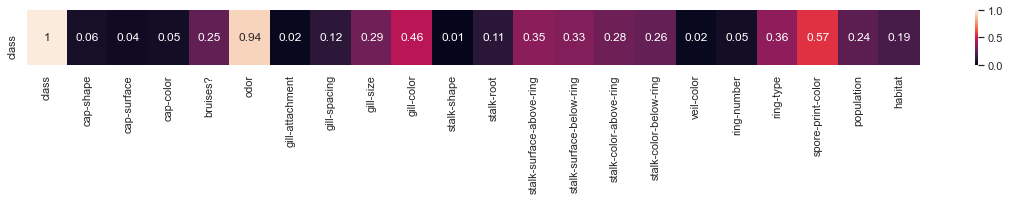

In [73]:
plt.figure(figsize=[20,1])
# Plotting correlation between class and other features heatmap
with sns.axes_style("white"):
    ax = sns.heatmap(pd.DataFrame(df_corr.iloc[:,0]).T,vmin=0., vmax=1, annot=True)
plt.show()

According to the heatmap, we can see that odor does have strong positive correlation with the class.
gill-color and spore-print-color has moderate correlation with the class

So according to the heatmap, the top 5 features that has correlation with the class are
-  odor
- spore-print-color
- gill-color
- stalk-surface-above-ring
- stalk-surface-below-ring

Out of the 5 features that contribute to our 3 models in prerdiciting class labels, only 3 of the features are represented in the heatmap which are odor, spore-print-color and gill-color.